## Imports and Utils

In [1]:
import pandas as pd
from pandas import concat, DataFrame
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB

In [27]:
data_file_path = 'data/diabetes_class_data.csv'
output_file_path = "./results.xlsx"
target = "readmitted"

df = pd.read_csv(data_file_path)

In [28]:
def excel(array):
  df = pd.DataFrame(array)
  df.to_excel(excel_writer = output_file_path)

## Test x Train x Val Split

In [29]:
def split(df, train_size = 0.8):
  X = df.drop(target, axis=1)
  y = df[target]
  X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=train_size)
  X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=0.5)
  return X_train, X_val, X_test, y_train, y_val, y_test

## Balancing

In [30]:
def plot_pca(train_data, train_target):
  pca = PCA(n_components=2)
  pca.fit(train_data)
  X_pca = pca.transform(train_data)
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_target, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
  plt.show()

0    88320
1    11169
Name: readmitted, dtype: int64


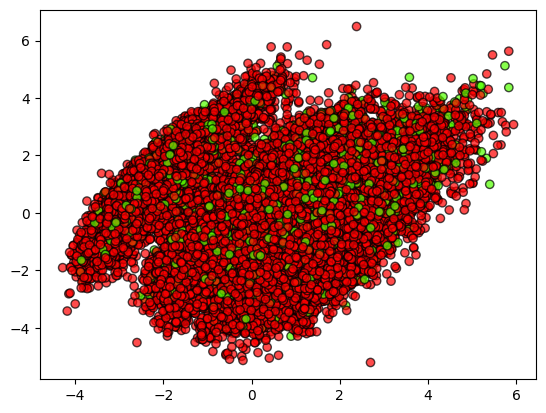

In [31]:
# train, test, val split
X_train, X_val, X_test, y_train, y_val, y_test = split(df)

counts = df[target].value_counts()
print(counts)
# Build and Plot PCA
plot_pca(X_train,y_train)

## Sampling

In [32]:
minority_class = np.argmin(counts)
majority_class = np.argmax(counts)

df_min = df[df[target] == minority_class]
df_maj = df[df[target] == majority_class]

### Oversampling

Minority class= 1 : 88320
Majority class= 0 : 88320
Proportion: 1.0 : 1


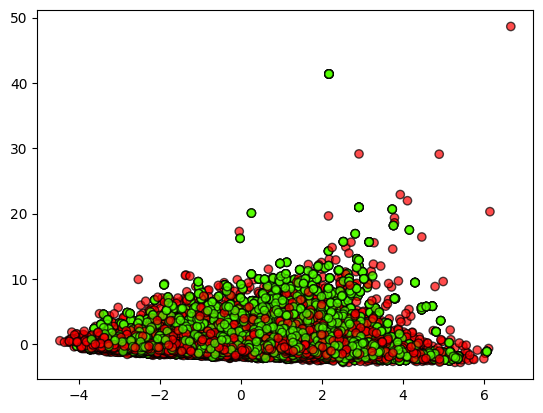

In [37]:
df_sample = DataFrame(df_min.sample(len(df_maj), replace=True))
df_over = concat([df_sample, df_maj], axis=0)
print('Minority class=', minority_class, ':', len(df_sample))
print('Majority class=', majority_class, ':', len(df_maj))
print('Proportion:', round(len(df_sample) / len(df_maj), 2), ': 1')

X_train, X_val, X_test, y_train, y_val, y_test = split(df_over)
plot_pca(X_train, y_train)

### Undersampling

Minority class= 1 : 11169
Majority class= 0 : 11169
Proportion: 1.0 : 1


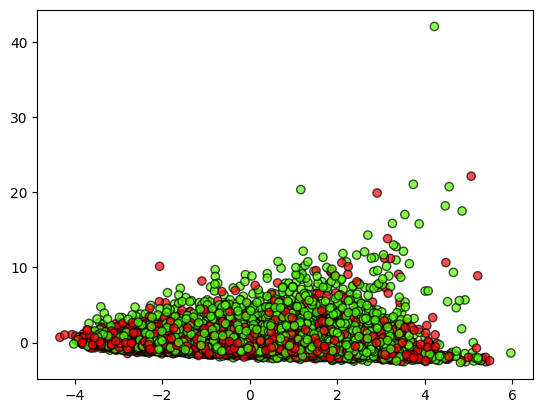

In [36]:
df_sample = DataFrame(df_maj.sample(len(df_min)))
df_under = concat([df_min, df_sample], axis=0)
print('Minority class=', 1, ':', len(df_min))
print('Majority class=', 0, ':', len(df_sample))
print('Proportion:', round(len(df_min) / len(df_sample), 2), ': 1')

X_train, X_val, X_test, y_train, y_val, y_test = split(df_under)
plot_pca(X_train, y_train)

### Sampling choice

In [38]:
df = df_under

## Training

In [41]:
X_train, X_val, X_test, y_train, y_val, y_test = split(df)

### Training and Evaluation Function

In [42]:
def predict_and_eval(clf, X_train, y_train, X, y ):
  clf = clf.fit(X_train,y_train)
  y_pred = clf.predict(X)
  acc =  metrics.accuracy_score(y, y_pred)
  return y_pred, acc, clf

### KNN

In [43]:
def KNN(k, w, d, X_train, y_train, X, y):
  clf = KNeighborsClassifier(
      n_neighbors=k, 
      metric=d, 
      weights=w
  )
  result = predict_and_eval(clf, X_train, y_train, X, y )
  return result

In [44]:
params = {
    'k':[1,3,5,7,10,15,20],
    'd':[
        'manhattan', 
        #  'euclidean', 
        #  'chebyshev'
         ],
    'w':[
        # 'uniform', 
         'distance'
         ],
} 

knn_accuracies = list()
best_knn_pred = 0
best_knn_acc = 0
best_knn_clf = 0

for w in params['w']:
  for d in params['d']:
    for k in tqdm(params['k']):
      pred, acc, clf = KNN(k,w,d,X_train,y_train,X_val,y_val)
      knn_accuracies.append([acc,k,d,w])
      if acc>best_knn_acc:
        best_knn_pred=pred
        best_knn_acc=acc
        best_knn_clf=clf

100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


In [45]:
knn_accuracies

[[0.5492390331244404, 1, 'manhattan', 'distance'],
 [0.5478961504028648, 3, 'manhattan', 'distance'],
 [0.5581915846016114, 5, 'manhattan', 'distance'],
 [0.5729632945389436, 7, 'manhattan', 'distance'],
 [0.5774395702775291, 10, 'manhattan', 'distance'],
 [0.5792300805729633, 15, 'manhattan', 'distance'],
 [0.5693822739480752, 20, 'manhattan', 'distance']]

### Naive Bayes

In [ ]:
def NB(Estimator, X_train, y_train, X, y):
  clf = Estimator()
  result = predict_and_eval(clf, X_train, y_train, X, y )
  return result

In [ ]:
nb_accuracies = list()
estimators = [
  GaussianNB, 
  MultinomialNB, 
  BernoulliNB, 
  CategoricalNB
]
best_nb_pred = 0
best_nb_acc = 0
best_nb_clf=0

for e in estimators:
  pred, acc, clf  = NB(e,X_train,y_train,X_val,y_val)
  nb_accuracies.append(acc)
  if acc>best_nb_acc:
    best_nb_pred=pred
    best_nb_acc=acc
    best_nb_clf=clf

In [ ]:
nb_accuracies

### Decision Tree

In [5]:
def DT(d, c, X_train, y_train, X, y):
  clf = DecisionTreeClassifier(
    criterion = c,
    max_depth = d
  )
  result = predict_and_eval(clf, X_train, y_train, X, y )
  return result

In [25]:
params = {
    'criterion': [
      "gini", 
      "entropy",
      "log_loss"
    ],
    'max_depth': [
      2, 
      5, 
      10, 
      15, 
      20,
      25
    ]
}
dt_accuracies = list()
best_dt_pred = 0
best_dt_acc = 0
best_dt_clf = 0

for c in params["criterion"]:
  for d in tqdm(params["max_depth"]):
    pred, acc, clf  = DT(d, c, X_train,y_train,X_train,y_train)
    dt_accuracies.append([acc,d,c])
    if acc>best_dt_acc:
      best_dt_pred=pred
      best_dt_acc=acc
      belt_dt_clf=clf

100%|██████████| 9/9 [00:11<00:00,  1.27s/it]


In [24]:
dt_accuracies

[[0.7622403006427092, 5, 'gini'], [0.6606879764268785, 2, 'gini']]

In [26]:
excel(dt_accuracies)

### MLP

In [18]:
def MLP(hs, lr, a, X_train, y_train, X, y):
  clf = MLPClassifier(
      hidden_layer_sizes=(hs,),
      learning_rate_init=lr,
      activation = a,
      # verbose=True,
      # learning_rate="adaptive"
    )
  result = predict_and_eval(clf, X_train, y_train, X, y )
  return result

In [ ]:
params = {
    'activation': [
      "logistic", 
      "tanh", 
      'relu'
    ],
    'hs': [
      50,
      100, 
      150, 
      200,
      250
    ],
    'lr': [
      0.001, 
      0.01, 
      0.05
    ]
}
mlp_accuracies = list()
best_mlp_pred = 0
best_mlp_acc = 0
best_mlp_clf=0

for a in params["activation"]:
  for hs in tqdm(params["hs"]):
    for lr in params["lr"]:
      pred, acc, clf  = MLP(hs, lr, a, X_train,y_train,X_val,y_val)
      mlp_accuracies.append([acc,a, hs, lr])
      if acc>best_mlp_acc:
        best_mlp_pred=pred
        best_mlp_acc=acc
        best_mlp_clf=clf

In [ ]:
mlp_accuracies

In [24]:
excel(mlp_accuracies)

### Random Forest

In [27]:
def RF(e, d, X_train, y_train, X, y):
  clf = RandomForestClassifier(
    n_estimators = e, 
    random_state = 42,
    max_depth = d,
    # verbose=True
  )
  result = predict_and_eval(clf, X_train, y_train, X, y )
  return result

In [ ]:
params={
    "estimators":[5, 10, 25, 50, 75, 100, 200, 300, 400],
    "max_depth":[
      5, 
      10, 
      25
    ]
}
rf_accuracies=list()
best_rf_pred = 0
best_rf_acc = 0
best_rf_clf=0

for d in params["max_depth"]:
  for e in tqdm(params["estimators"]):
    pred, acc, clf = RF(e, d, X_train,y_train,X_val,y_val)
    rf_accuracies.append([acc,e, d])
    if acc>best_rf_acc:
        best_rf_pred=pred
        best_rf_acc=acc
        best_rf_clf=clf

In [ ]:
rf_accuracies

In [38]:
excel(rf_accuracies)

### Gradiant Boosting

In [47]:
def GB(e, lr, X_train, y_train, X, y):
  clf = GradientBoostingClassifier(
      learning_rate = lr,
      n_estimators = e,
      # n_iter_no_change = 50
  )
  result = predict_and_eval(clf, X_train, y_train, X, y )
  return result

In [49]:
params={
    "estimators":[
      400, 
      # 450,
      # 500,
      # 550, 
      # 600
    ],
    "lr":[
      0.1,
      # 0.3,
      # 0.5,
      # 0.6,
      # 0.7
    ]
}
gb_accuracies=list()
best_gb_pred = 0
best_gb_acc = 0
best_gb_clf=0

for lr in params["lr"]:
  for e in tqdm(params["estimators"]):
    pred, acc, clf = GB(e, lr, X_train,y_train,X_val,y_val)
    gb_accuracies.append([acc, lr, e])
    if acc>best_gb_acc:
        best_gb_pred=pred
        best_gb_acc=acc
        best_gb_clf=clf

100%|██████████| 1/1 [00:08<00:00,  8.20s/it]


In [50]:
gb_accuracies

[[0.6329453894359892, 0.1, 400]]

In [56]:
excel(gb_accuracies)

## Classifier Analysis

### Loss Curve

In [ ]:
plt.plot(clf.loss_curve_)
plt.title('Loss Curve')
plt.show()

### Feature Importace

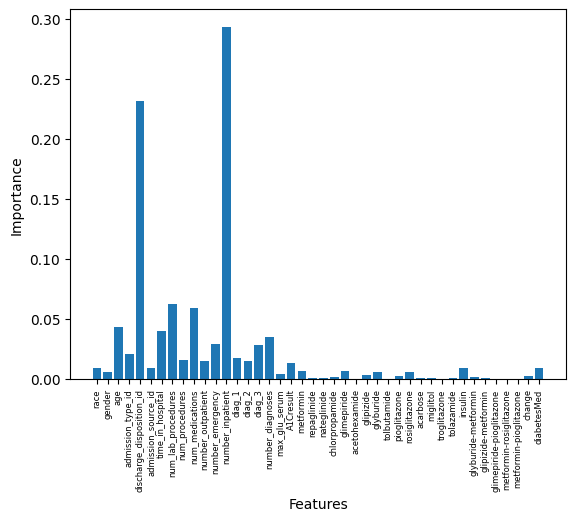

In [55]:
importances = clf.feature_importances_
plt.bar(list(X_test), importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(fontsize=6, rotation = 90)
plt.show()

### Max Depth

In [ ]:
d=[estimator.tree_.max_depth for estimator in clf.estimators_]
max(d)

43

### Classification Report

In [64]:
def report(clf, X, y):
  y_pred = clf.predict(X)
  print('\n', metrics.classification_report(y, y_pred))
  print('\nConfusion Matrix\n', metrics.confusion_matrix(y, y_pred))
  return(y_pred)

In [65]:
report(best_knn_clf, X_test, y_test)


               precision    recall  f1-score   support

           0       0.57      0.61      0.59      1130
           1       0.57      0.53      0.55      1104

    accuracy                           0.57      2234
   macro avg       0.57      0.57      0.57      2234
weighted avg       0.57      0.57      0.57      2234


Confusion Matrix
 [[685 445]
 [516 588]]


array([0, 0, 1, ..., 0, 1, 1])

: 